**Author:** Álvaro Guerrero Gallego

**Project:** TFG Business Analytics

# Pairs Selection

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats import norm
from scipy.stats import skew

from datetime import datetime, timedelta

import multiprocessing
from joblib import Parallel, delayed

## Data preparation

In [2]:
# Step 1: Load the DJIA price data
df = pd.read_parquet('data/djiak_impl_vols.parquet')

df.head()

,Id,Date,ff_isin,p_price,p_opt_atmiv_mkt,company
0,WBA-US,1990-09-21,US9314271084,2.828125,NaN,WBA-US
1,WBA-US,1990-09-24,US9314271084,2.750000,NaN,WBA-US
2,WBA-US,1990-09-25,US9314271084,2.773438,NaN,WBA-US
3,WBA-US,1990-09-26,US9314271084,2.742188,NaN,WBA-US
4,WBA-US,1990-09-27,US9314271084,2.726562,NaN,WBA-US


In [3]:
# Define the window size and step size of the pairs construction
YEAR = 252 # a month has approximately 252 trading days (252 samples)
window_size = 3 * YEAR  # 3 years - 756 samples
step_size = YEAR // 2  # 6 months - 126 samples 

In [4]:
# Step 2: process the df
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # Convert column date to datetime
df = df[df['Date']>='2003-01-01']    # filter the df so it only mantains the desired dates (we have to take one day prior to the first to do the estimations)

df = df[-df['p_price'].isna()]  # Eliminate rows that have no stock prices
df['Id'] = df['Id'].str.replace('-', '_') # Change name of the columns to avoid calculation issues

In [5]:
# Step 3: Transform the dataset to obtain the stock prices in the desired format
series01 = df.pivot(index='Date', columns='Id', values='p_price')
series01 = series01.sort_index()

# Drop columns with missing values
series01 = series01.dropna(axis=1)

series01.head()

Id,AAPL_US,AMGN_US,AXP_US,BA_US,CAT_US,CSCO_US,CVX_US,DIS_US,GS_US,HD_US,...,MMM_US,MRK_US,MSFT_US,NKE_US,PG_US,TRV_US,UNH_US,VZ_US,WBA_US,WMT_US
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-02,0.264286,49.32,36.67,33.88,23.875,13.64,33.910,17.26,69.65,24.88,...,63.375,58.25,26.860,5.76250,43.905,35.08,21.4275,40.17,30.10,51.60
2003-01-03,0.266071,49.19,36.80,34.18,23.715,13.91,34.170,17.36,70.38,21.38,...,63.135,58.99,26.895,5.64375,43.425,35.07,21.6450,40.45,32.16,50.00
2003-01-06,0.266071,50.27,38.09,34.13,24.200,14.20,34.950,18.25,73.00,21.82,...,63.595,59.88,27.385,5.72250,43.920,36.66,21.1000,44.07,31.45,50.19
2003-01-07,0.265179,50.24,37.58,33.30,23.925,14.60,34.225,18.05,72.70,21.46,...,63.535,59.11,27.900,5.70750,43.245,36.00,20.9450,43.62,31.94,50.46
2003-01-08,0.259821,48.88,37.30,33.50,23.200,14.44,34.025,17.68,70.92,21.16,...,62.850,58.98,27.120,5.75250,42.600,34.90,21.1250,40.91,31.80,49.99


## Maximum Likelihood estimation (3 years, rolling 6 months)

In [6]:
# Count all Possible Pairs
import itertools
all_pairs = list(itertools.combinations(series01.columns, 2))

print(f"Number Formed {len(all_pairs)} total pairs by permutation")

Number Formed 351 total pairs by permutation


In [7]:
def estimate_parameters(y, x, Delta_t=1):
    """
    Estimate the parameters of the continuous mispricing model.

    Args:
        y (ndarray): Prices of asset y.
        x (ndarray): Prices of asset x.
        Delta_t (float): Time interval between observations (usually 1 day)

    Returns:
        tuple: Estimated parameters (mu_y, mu_x, lambda_1, lambda_2, sigma_y, sigma_x, rho_xy).
    """

    # Calculate the logarithmic prices
    Y = np.log(y)
    X = np.log(x)

    # Calculate the differences and spread
    A = Y[1:] - Y[:-1]
    B = X[1:] - X[:-1]
    z = Y[:-1] - X[:-1]

    # Obtain the number of observations
    n = len(z)
    
    # Estimate lambda_1 and lambda_2
    denominator = Delta_t * np.sum((z - np.mean(z))**2)
    lambda_1 = 2 * np.sum((A - np.mean(A)) * (z - np.mean(z))) / denominator
    lambda_2 = 2 * np.sum((B - np.mean(B)) * (z - np.mean(z))) / denominator
    
    # Estimate sigma_y and sigma_x
    sigma_y = np.sqrt(np.sum(((A - np.mean(A)) - lambda_1 * Delta_t * (z - np.mean(z)))**2) / (n * Delta_t))
    sigma_x = np.sqrt(np.sum(((B - np.mean(B)) - lambda_2 * Delta_t * (z - np.mean(z)))**2) / (n * Delta_t))

    # Estimate mu_y and mu_x
    mu_y = np.sum(A / Delta_t + lambda_1 * z + 0.5 * sigma_y**2) / n
    mu_x = np.sum(B / Delta_t - lambda_2 * z + 0.5 * sigma_x**2) / n
    
    # Calculate Z_y and Z_x
    Z_y = (A - (mu_y - lambda_1 * z - 0.5 * sigma_y**2) * Delta_t) / (sigma_y * np.sqrt(Delta_t))
    Z_x = (B - (mu_x + lambda_2 * z - 0.5 * sigma_x**2) * Delta_t) / (sigma_x * np.sqrt(Delta_t))
    
    # Calculate rho_xy
    rho_xy = np.mean(Z_y * Z_x)
    
    return mu_y, mu_x, lambda_1, lambda_2, sigma_y, sigma_x, rho_xy

In [8]:
def process_pair(pair, series01, window_size, step_size):
    stock_y, stock_x = pair
    valid_parameters_list = []

    prices1 = series01[stock_y]
    prices2 = series01[stock_x]

    num_windows = (len(prices1) - window_size + 1) // step_size

    for i in range(num_windows):
        start_idx = i * step_size + 1
        end_idx = start_idx + window_size

        window_prices1 = prices1.iloc[start_idx-1:end_idx]  # we pass one more sample to do the price diff calculations
        window_prices2 = prices2.iloc[start_idx-1:end_idx]

        mu_y, mu_x, lambda_1, lambda_2, sigma_y, sigma_x, rho_xy = estimate_parameters(
            window_prices1.values, window_prices2.values, 1
        )

        stability_condition = lambda_1 + lambda_2 > 0 
        cointegration_condition = lambda_1 * lambda_2 < 0   # opposite signs

        if stability_condition and cointegration_condition:
            valid_parameters = {
                'Stock_y': stock_y,
                'Stock_x': stock_x,
                'Start_Date': window_prices1.index[1],
                'End_Date': window_prices1.index[-1],
                'mu_y': mu_y,
                'mu_x': mu_x,
                'lambda_1': lambda_1,
                'lambda_2': lambda_2,
                'sigma_y': sigma_y,
                'sigma_x': sigma_x,
                'rho_xy': rho_xy
            }

            valid_parameters_list.append(valid_parameters)

    return valid_parameters_list

In [9]:
def perform_parallel_processing(all_pairs, series01, window_size, step_size):
    # Determine the number of CPU cores
    num_cores = multiprocessing.cpu_count() - 1

    # Perform parallel processing
    results = Parallel(n_jobs=num_cores, verbose=10)(
        delayed(process_pair)(pair, series01, window_size, step_size) for pair in all_pairs
    )

    # Flatten the results
    parameters_list = [param for sublist in results for param in sublist]

    # Create a DataFrame from the list of parameters
    pairs_df = pd.DataFrame(parameters_list)

    return pairs_df

In [10]:
# Perform the estimation with the MLE method
pairs_df = perform_parallel_processing(all_pairs, series01, window_size, step_size)
pairs_df.to_csv('output/pairs_MLE.csv', index=False)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    7.6s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    7.8s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    7.8s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    7.9s
[Parallel(n_jobs=7)]: Batch computation too fast (0.1913s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    8.0s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:    8.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.1495s.) Setting batch_size=4.
[Parallel(n_jobs=7)]: Done  67 tasks      | elapsed:    8.3s
[Parallel(n_jobs=7)]: Done 109 tasks      | elapsed:    8.8s
[Parallel(n_jobs=7)]: Done 161 tasks      | elapsed:    9.1s
[Parallel(n_jobs=7)]: Done 221 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done 281 tasks      | elapsed:   10.0s
[Parallel(n_jobs=7)]: Done 331 tasks      | elapsed:   10.4s
[Parallel(n_jobs=7)]: Done 351 out of 351 | elapsed:   10.5s finished


In [11]:
# Read the DataFrame from the CSV file
pairs_df = pd.read_csv('output/pairs_MLE.csv')
pairs_df.tail()

,Stock_y,Stock_x,Start_Date,End_Date,mu_y,mu_x,lambda_1,lambda_2,sigma_y,sigma_x,rho_xy
3436,VZ_US,WMT_US,2018-07-11,2021-07-12,0.001158,0.006735,-0.001342,0.008372,0.012423,0.014560,0.461665
3437,VZ_US,WMT_US,2019-01-10,2022-01-07,0.001669,0.008096,-0.002102,0.009392,0.011895,0.013925,0.447999
3438,WBA_US,WMT_US,2005-01-04,2008-01-04,0.000977,0.001152,-0.015793,0.018659,0.013917,0.011036,0.314555
3439,WBA_US,WMT_US,2006-07-06,2009-07-07,0.000297,0.001061,-0.002206,0.002934,0.020555,0.016632,0.505062
3440,WBA_US,WMT_US,2008-01-07,2011-01-04,0.003577,0.005807,-0.006377,0.010974,0.020912,0.015467,0.541932


In [12]:
pairs_df_annual = pairs_df.groupby('End_Date')['Stock_y'].count()
pairs_df_annual

End_Date
2006-01-03    104
2006-07-05    100
2007-01-04    119
2007-07-06    114
2008-01-04    107
2008-07-07     75
2009-01-05     94
2009-07-07    111
2010-01-05    118
2010-07-07    103
2011-01-04    106
2011-07-06     95
2012-01-04    108
2012-07-05     62
2013-01-07     87
2013-07-09     85
2014-01-07     90
2014-07-09     90
2015-01-07    102
2015-07-09     88
2016-01-07     63
2016-07-08    101
2017-01-06    108
2017-07-10     92
2018-01-08     85
2018-07-10     99
2019-01-09    114
2019-07-11    139
2020-01-09    137
2020-07-10    128
2021-01-08     99
2021-07-12    102
2022-01-07    121
2022-07-12     95
Name: Stock_y, dtype: int64

In [13]:
# Group by the period column and calculate statistics
statistics = pairs_df_annual.agg(['count', 'mean', 'std', 'max', 'min'])

# Print the statistics
statistics.head()

count     34.000000
mean     101.205882
std       17.462999
max      139.000000
min       62.000000
Name: Stock_y, dtype: float64

## Johansen test cointegration

In [14]:
def process_pair_johansen(pair, series01, window_size, step_size, cointegration_confidence_level=95):
    stock_y, stock_x = pair
    parameters_list = []

    prices1 = np.log(series01[stock_y])
    prices2 = np.log(series01[stock_x])

    num_windows = (len(prices1) - window_size + 1) // step_size

    confidence_level_cols = {
        90: 0,
        95: 1,
        99: 2
    }
    confidence_level_col = confidence_level_cols[cointegration_confidence_level]

    for i in range(num_windows):
        start_idx = i * step_size + 1
        end_idx = start_idx + window_size

        window_prices1 = prices1.iloc[start_idx-1:end_idx]  # we pass one more sample to do it as in the MLE
        window_prices2 = prices2.iloc[start_idx-1:end_idx]

        result = coint_johansen(np.column_stack((window_prices1.values, window_prices2.values)), 0, 1) 
        trace_crit_value = result.cvt[:, confidence_level_col]

        if result.lr1[0] >= trace_crit_value[0]:
            parameters = {
                'Stock_y': stock_y,
                'Stock_x': stock_x,
                'Start_Date': window_prices1.index[1],
                'End_Date': window_prices1.index[-1]
            }
            parameters_list.append(parameters)

    return parameters_list


In [15]:
def perform_parallel_processing_johansen(all_pairs, series01, window_size, step_size, confidence_level=95):
    # Determine the number of CPU cores
    num_cores = multiprocessing.cpu_count() - 1

    # Perform parallel processing
    results = Parallel(n_jobs=num_cores, verbose=10)(
        delayed(process_pair_johansen)(pair, series01, window_size, step_size, confidence_level) for pair in all_pairs
    )

    # Flatten the results
    parameters_list = [param for sublist in results for param in sublist]

    # Create a DataFrame from the list of parameters
    parameters_df = pd.DataFrame(parameters_list)

    return parameters_df

In [16]:
# Perform the estimation with the Johansen method
pairs_df_johansen = perform_parallel_processing_johansen(all_pairs, series01, window_size, step_size, 95)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    3.1s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:    3.8s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    4.2s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:    4.7s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:    5.1s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:    5.6s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:    6.2s
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:    6.9s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:    7.6s
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:    8.3s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    9.0s
[Parallel(n_jobs=7)]: Done 207 tasks      | elapsed:    9.7s
[Parallel(n_jobs=7)]: Do

In [17]:
pairs_df_johansen.tail()

,Stock_y,Stock_x,Start_Date,End_Date
1784,WBA_US,WMT_US,2008-01-07,2011-01-04
1785,WBA_US,WMT_US,2014-07-10,2017-07-10
1786,WBA_US,WMT_US,2015-01-08,2018-01-08
1787,WBA_US,WMT_US,2018-07-11,2021-07-12
1788,WBA_US,WMT_US,2019-01-10,2022-01-07


In [18]:
pairs_df_johansen_annual = pairs_df_johansen.groupby('Start_Date')['Stock_y'].count().head(32)
pairs_df_johansen_annual.head()

Start_Date
2003-01-03    36
2003-07-07    57
2004-01-05    24
2004-07-07    36
2005-01-04    38
Name: Stock_y, dtype: int64

In [19]:
# Calculate statistics of pair counts per period
statistics_johansen = pairs_df_johansen_annual.agg(['count', 'mean', 'std', 'max', 'min'])
# Print the statistics
statistics_johansen.head()

count     32.000000
mean      52.656250
std       34.456714
max      155.000000
min       13.000000
Name: Stock_y, dtype: float64

**Much lower number of pairs**

# Portfolio Optimization

## Data preparation

In [20]:
# Get all the estimation period ending dates
unique_end_dates = pairs_df["End_Date"].unique()
# Find the first trading date
first_trading_day = np.min(unique_end_dates)
# Maintain only the trading period in the dataset
df = df[df['Date'] >= first_trading_day]
# Check the first trading day (it must be later than the first data point of impl_vol
print(first_trading_day)

2006-01-03


In [21]:
# Check number of NAs per stock in implied_vols
df[df['p_opt_atmiv_mkt'].isna()]["Id"].value_counts()

TRV_US     290
AAPL_US     74
DOW_US      10
V_US         8
CRM_US       7
MRK_US       7
JPM_US       6
KO_US        6
UNH_US       6
HD_US        6
MCD_US       6
CSCO_US      6
WMT_US       6
INTC_US      6
DIS_US       6
AXP_US       6
NKE_US       6
BA_US        6
GS_US        6
PG_US        6
AMGN_US      6
IBM_US       6
CVX_US       6
MMM_US       6
VZ_US        6
JNJ_US       6
HON_US       6
WBA_US       6
MSFT_US      5
CAT_US       5
Name: Id, dtype: int64

In [22]:
# interpolate to get rid of the impl vols NAs
df['p_opt_atmiv_mkt'] = df['p_opt_atmiv_mkt'].interpolate()

In [23]:
# Step 2.2: process the implied volatilities df
series02 = df.pivot(index='Date', columns='Id', values='p_opt_atmiv_mkt')
series02 = series02.sort_index()
# Drop columns with missing values (to have the same number of stocks as in series01)
series02 = series02.dropna(axis=1)

series02.head()

Id,AAPL_US,AMGN_US,AXP_US,BA_US,CAT_US,CRM_US,CSCO_US,CVX_US,DIS_US,GS_US,...,MMM_US,MRK_US,MSFT_US,NKE_US,PG_US,TRV_US,UNH_US,VZ_US,WBA_US,WMT_US
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,44.63911,23.85388,22.00386,22.93976,26.82082,50.02278,25.12196,23.27683,23.24922,22.48629,...,19.82809,24.18623,27.88103,38.84167,19.78711,33.192009,27.73199,23.31878,21.24525,20.77093
2006-01-04,43.77833,23.86637,22.34347,22.75446,27.13268,50.70045,24.93130,23.59581,26.54395,22.52730,...,19.90493,24.53257,29.17410,47.48794,20.01344,33.142202,28.56310,22.47712,21.53160,20.95422
2006-01-05,42.70568,24.20720,22.20046,22.59533,26.97030,50.55409,25.14742,23.61297,24.64569,22.63871,...,20.06236,24.29449,22.07508,21.60898,19.72808,33.092395,29.27639,23.71449,21.20576,21.03352
2006-01-06,43.03213,24.35499,21.88959,22.68398,26.96407,56.53069,24.70038,23.01641,24.82918,22.20209,...,19.95103,24.61586,28.45426,21.85301,19.20816,33.042587,27.36896,24.42130,20.95277,20.85530
2006-01-09,43.09848,24.61107,22.10103,22.74853,26.72227,56.95804,24.73469,23.83107,24.04584,22.53399,...,19.98489,24.55279,29.80003,26.24824,19.06758,32.992780,32.02700,25.97610,21.21750,21.40640


In [24]:
## Modify the stock price series to have also information since the first trading day
series01 = series01[first_trading_day:]
# Check that the number of samples is the same
len(series01)==len(series02)

True

In [25]:
# Step 3.2: load the risk-free rates df (6-month treasury rates)
rates_df = pd.read_csv('data/DTB6.csv')
rates_df.head()

,DATE,DTB6
0,1997-01-02,5.140
1,1997-01-03,5.130
2,1997-01-06,5.120
3,1997-01-07,5.100
4,1997-01-08,5.100


In [26]:
# Process the rates df
rates_df['DATE'] = pd.to_datetime(rates_df['DATE'])
# Process the rates
rates_df['DTB6'] = pd.to_numeric(rates_df['DTB6'], errors='coerce')
# interpolate to get rid of the rates NAs
rates_df['DTB6'] = rates_df['DTB6'].interpolate()
# Maintain only the trading period in the dataset
rates_df = rates_df[rates_df['DATE'] >= first_trading_day]
# Maintain only the dates for witch we have stock prices data
rates_df = rates_df[rates_df['DATE'].isin(series01.index)]
# Put the dates as the index
rates_df.set_index('DATE', inplace=True)
# Check that the number of samples is the same
len(rates_df)==len(series01)

True

## Optimization parameters calculation

### Calculate all information needed for the Out-of-sample (6-month option)

In [30]:
def process_pair_oos(pairs_df_filtered, series01_filtered, series02_filtered, rates_filtered):
    parameters_list = []

    # Iterate over the rows of the filtered DataFrame
    for _, row in pairs_df_filtered.iterrows():
        stock_y = row['Stock_y']
        stock_x = row['Stock_x']

        # Get the interest rate
        r = rates_filtered/100
        
        # Get the prices of the stock pair
        price_y = series01_filtered[stock_y]
        price_x = series01_filtered[stock_x]

        # Get the implied volatilities
        sigma_y = series02_filtered[stock_y]/100
        sigma_x = series02_filtered[stock_x]/100

        # Compute the log spread of the pair
        z_spread = np.log(price_y/price_x)

        # Compute the volatilities for the stock spread with the ATM vols
        sigmaRN_z = np.sqrt(sigma_y**2 + sigma_x**2 - 2 * sigma_y * sigma_x * row["rho_xy"])

        # proportion of days until the next maturity date in years
        k = np.arange(len(z_spread), 0, -1) / YEAR

        # Help variable that is used a lot
        sigma_T = sigmaRN_z * np.sqrt(k)

        # Calculate d1 and d2 based on the formulas
        d1 = (abs(z_spread) + (r + 0.5 * sigmaRN_z**2) * k) / sigma_T
        d2 = d1 - sigma_T

        # Calculate delta_y and delta_x using the norm.cdf function
        delta_y = norm.cdf(d1)
        delta_x = norm.cdf(d2)

        # Compute the gammas
        gamma_y = norm.pdf(d1) / (price_y * sigma_T)
        gamma_x = norm.pdf(d2) / (price_x * sigma_T)

        # Compute the determinant of the Jacobi matrix
        open = (1 -row["lambda_1"] - row["lambda_2"]) * sigmaRN_z
        close_formula = (gamma_x**2 / gamma_y**2) - price_y / price_x
        close = close_formula[1:]*close_formula[:-1]

        # Compute the trigger
        trigger = trigger = np.where(close <= 0, 0,
                                np.where(z_spread > open, 1, np.nan))

        # Iterate over the dates
        for j, date in enumerate(z_spread.index):
            # Add the pair of stocks, date, and other parameters to the list
            parameters = {
                'Date': date,
                'Stock_y': stock_y,
                'Stock_x': stock_x,
                'Price_y': price_y[date],
                'Price_x': price_x[date],
                'Vol_y': sigma_y[date],
                'Vol_x': sigma_x[date],
                'Time_to_mat_years': k[j],
                'spread_z': z_spread[date],
                'sigmaRN_z': sigmaRN_z[date],
                'Delta_y': delta_y[j],
                'Delta_x': delta_x[j],
                'Gamma_y': gamma_y[date],
                'Gamma_x': gamma_x[date],
                'Trigger': trigger[j]
            }
            parameters_list.append(parameters)

    return parameters_list

In [31]:
# create a volatility values list
oos_parameters_list = []

# Determine the number of CPU cores
num_cores = multiprocessing.cpu_count() - 1

# Iterate over unique_end_dates with index using Parallel processing
results = Parallel(n_jobs=num_cores, verbose=10)(delayed(process_pair_oos)(pairs_df[pairs_df["End_Date"] == end_date],
                                                           series01[end_date:].head(step_size),
                                                           series02[end_date:].head(step_size),
                                                           rates_df[end_date:]["DTB6"].head(step_size))
                                      for end_date in unique_end_dates)

# Flatten the results list
oos_parameters_list = [parameters for sublist in results for parameters in sublist]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   30.8s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   40.0s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   48.2s
[Parallel(n_jobs=7)]: Done  25 out of  34 | elapsed:   55.6s remaining:   20.0s
[Parallel(n_jobs=7)]: Done  29 out of  34 | elapsed:  1.0min remaining:   10.4s
[Parallel(n_jobs=7)]: Done  34 out of  34 | elapsed:  1.1min finished


In [32]:
# Convert the list to a df
oos_df = pd.DataFrame(oos_parameters_list)
# Check lenght
len(oos_df["Date"].unique())

4284

In [33]:
# Save the table in a csv file
oos_df.to_csv('output/oos_MLE_DJIA.csv', index=False)

In [34]:
# Read the DataFrame from the CSV file
oos_df = pd.read_csv('output/oos_MLE_DJIA.csv')
oos_df.tail()

,Date,Stock_y,Stock_x,Price_y,Price_x,Vol_y,Vol_x,Time_to_mat_years,spread_z,sigmaRN_z,Delta_y,Delta_x,Gamma_y,Gamma_x,Trigger
433561,2008-06-27,WBA_US,WMT_US,32.97,56.30,0.296558,0.272209,0.019841,-0.535096,0.333555,1.0,1.0,1.218602e-29,1.219103e-29,NaN
433562,2008-06-30,WBA_US,WMT_US,32.51,56.20,0.303642,0.272357,0.015873,-0.547369,0.338156,1.0,1.0,2.831561e-37,2.832514e-37,NaN
433563,2008-07-01,WBA_US,WMT_US,32.43,57.03,0.298530,0.274667,0.011905,-0.564494,0.336121,1.0,1.0,8.141110e-53,8.143126e-53,NaN
433564,2008-07-02,WBA_US,WMT_US,31.39,56.50,0.313248,0.280774,0.007937,-0.587751,0.348750,1.0,1.0,5.370241e-79,5.371115e-79,NaN
433565,2008-07-03,WBA_US,WMT_US,31.45,56.60,0.310722,0.279045,0.003968,-0.587610,0.346218,1.0,1.0,9.233992e-159,9.234739e-159,NaN


In [35]:
oos_df["Trigger"].describe()

count    188970.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: Trigger, dtype: float64

## Pairs trading returns

In [36]:
# Define a function to take the deltas and the triggers and return the position sizes
def position_sizes(delta_y, delta_x, trigger):
    """
    This function essentially determines the position sizes based on the deltas and triggers. 
    It assumes that a position is opened when the trigger changes from 0 to 1 and is closed when the trigger changes from 1 to 0.
    """
    y_pos = []
    x_pos = []
    d_y = np.nan
    d_x = np.nan
    k = np.nan
    
    for i in range(len(trigger)):
        y_pos.append(d_y) # do not trade until the next trading day since we check the trigger
        x_pos.append(d_x)
        if trigger[i]== 0:
            k = np.nan
            d_y = np.nan
            d_x = np.nan
        elif trigger[i] != k and not np.isnan(trigger[i]):
            k = trigger[i]
            d_y = k * delta_y[i]   # short
            d_x = -k * delta_x[i]   # long  

    return np.array(y_pos), np.array(x_pos)

In [37]:
def calculate_returns(pair_data):
    # Apply the position_sizes function to create new column for the position size
    position_size_y, position_size_x = position_sizes(pair_data['Delta_y'].values, pair_data['Delta_x'].values, pair_data['Trigger'].values)

    # Get the pair prices
    price_y = pair_data['Price_y']
    price_x = pair_data['Price_x']

    returns_y = position_size_y[1:] * np.diff(price_y) / (abs(position_size_y[:-1])*price_y[:-1])
    returns_x = -position_size_x[1:] * np.diff(price_x) / (abs(position_size_y[:-1])*price_x[:-1])

    pair_returns = returns_y + returns_x 

    # Return the results for each pair (first return is always Nan)
    return pair_returns

In [38]:
num_batches = len(oos_df) // step_size # // takes the largest integer
returns_dict = {}
return_counts = {}

for i in range(num_batches):
    start_index = i * step_size
    end_index = start_index + step_size
    batch = oos_df.iloc[start_index:end_index]

    if not np.isnan(batch["Trigger"]).all():
        batch.index = batch["Date"]
        returns = calculate_returns(batch)
        for date, ret in zip(batch.index, returns):
            if not np.isnan(ret):
                if date in returns_dict:
                    returns_dict[date] += ret
                    return_counts[date] += 1
                else:
                    returns_dict[date] = ret
                    return_counts[date] = 1

In [39]:
# Convert the dictionaries into dataframes
returns_df = pd.DataFrame.from_dict(returns_dict, orient='index', columns=['Returns'])
counts_df = pd.DataFrame.from_dict(return_counts, orient='index', columns=['Count'])

# Merge the two DataFrames on the index (date)
combined_df = pd.merge(returns_df, counts_df, left_index=True, right_index=True)

# Optional: Sort the DataFrame by the index (date) if needed
combined_df = combined_df.sort_index()

# Calculate the average returns of all the parirs
combined_df['Daily_Return'] = combined_df['Returns'] / combined_df['Count']

combined_df.head()

,Returns,Count,Daily_Return
2006-01-04,0.085841,51,0.001683
2006-01-05,0.485356,51,0.009517
2006-01-06,0.784838,51,0.015389
2006-01-09,-0.044773,51,-0.000878
2006-01-10,0.271346,51,0.005321


In [42]:
# Convert the index to datetime if it's not already in datetime format
combined_df.index = pd.to_datetime(combined_df.index)

# Extract the year from the index and create a new "Year" column
combined_df['Year'] = combined_df.index.year

# Calculate the cumulative returns
combined_df['Cumulative_Return'] = combined_df['Daily_Return'] + 1

# Group the data by year and calculate annual returns
annual_returns = combined_df.groupby('Year')['Cumulative_Return'].prod() - 1

# add 6 months US treasury rates to calculate the annual excess returns
combined_df['Cumulative_Excess_Return'] = combined_df['Daily_Return'] + 1 - (rates_df['DTB6']/100)/YEAR

# Daily excess returns
combined_df['Daily_Excess_Return'] = combined_df['Daily_Return'] - (rates_df['DTB6']/100)/YEAR

# Group the data by year and calculate annual excess returns
annual_excess_returns = combined_df.groupby('Year')['Cumulative_Excess_Return'].prod() - 1

In [43]:
# Calculate the annual Sharpe ratio
annual_std = combined_df.groupby('Year')['Daily_Excess_Return'].std() * np.sqrt(YEAR)  # Should I use Daily or cumulative returns?
sharpe_ratio = annual_excess_returns / annual_std   # do I need to subtract the risk free rate?

In [44]:
# Combine the results into a DataFrame
results_df = pd.DataFrame({
    'Annual Returns': annual_returns[:-1],
    'Annual Excess Returns': annual_excess_returns[:-1],
    'Sharpe Ratio': sharpe_ratio[:-1]
})

results_df

,Annual Returns,Annual Excess Returns,Sharpe Ratio
Year,,,
2006,0.312078,0.251506,1.285720
2007,0.160465,0.111242,0.370449
2008,-0.490365,-0.498397,-0.660512
2009,0.469868,0.465853,0.927616
2010,0.125589,0.123421,0.421666
2011,0.114719,0.113681,0.280572
2012,0.261880,0.260228,1.102536
2013,0.668115,0.666668,3.204735
2014,0.355304,0.354446,1.529668


In [46]:
results_df.describe()

,Annual Returns,Annual Excess Returns,Sharpe Ratio
count,17.000000,17.000000,17.000000
mean,0.189605,0.176374,0.894742
std,0.285105,0.285073,1.181290
min,-0.490365,-0.498397,-0.660512
25%,-0.032139,-0.035544,-0.051901
50%,0.227196,0.221708,0.878959
75%,0.371176,0.370315,1.486791
max,0.668115,0.666668,3.488431


In [48]:
# Other relevant statistics - skew
skewness = skew(combined_df['Daily_Excess_Return'])
# print the results
print('Skewness: %.2f' % skewness)

Skewness: 0.07


In [49]:
# Other relevant statistics - max and min daily returns
# Calculate the minimum daily return
min_annual_return = combined_df['Daily_Excess_Return'].min()
# Calculate the maximum daily return
max_annual_return = combined_df['Daily_Excess_Return'].max()
# Print the results
print("The minimum daily return is {:.2f}%".format(min_annual_return*100))
print("The maximum daily return is {:.2f}%".format(max_annual_return*100))


The minimum daily return is -21.44%
The maximum daily return is 21.78%


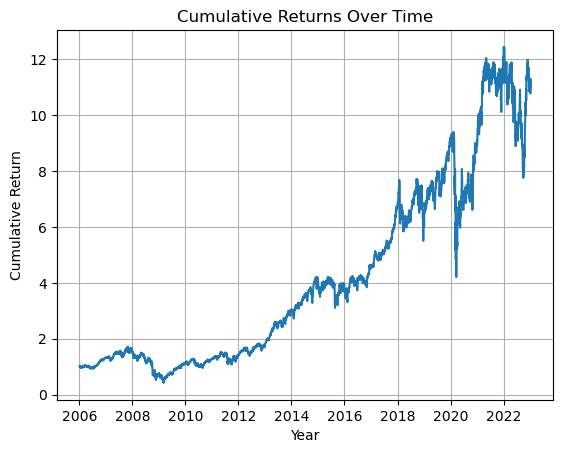

In [50]:
# Calculate cumulative returns
combined_df['Cum_returns'] = (1 + combined_df['Daily_Return']).cumprod()

# Plot the cumulative returns over time
plt.plot(combined_df.index, combined_df['Cum_returns'])
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.grid(True)
plt.show()

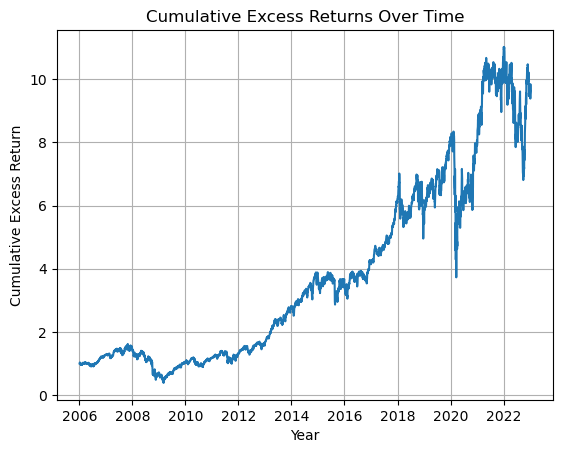

In [51]:
# Calculate cumulative returns
combined_df['Cum_excess_returns'] = (1 + combined_df['Daily_Return']- (rates_df['DTB6']/100)/365).cumprod() 

# Plot the cumulative returns over time
plt.plot(combined_df.index, combined_df['Cum_excess_returns'])
plt.xlabel('Year')
plt.ylabel('Cumulative Excess Return')
plt.title('Cumulative Excess Returns Over Time')
plt.grid(True)
plt.show()

### Results by period (instead of year)

In [52]:
# Convert the index to datetime if it's not already in the datetime format
df.index = pd.to_datetime(df.index)

# Define the custom date periods using the offset alias or frequency string
# For example, grouping by custom periods of 3 months
custom_period = pd.Grouper(freq='6M')

# Group the data by year and calculate semiannual returns
semiannual_returns = combined_df.groupby(custom_period)['Cumulative_Return'].prod() - 1

# Group the data by year and calculate semiannual excess returns
semiannual_excess_returns = combined_df.groupby(custom_period)['Cumulative_Excess_Return'].prod() - 1

In [53]:
# Calculate the annual Sharpe ratio
semiannual_std = combined_df.groupby(custom_period)['Cumulative_Excess_Return'].std() * np.sqrt(YEAR/2)  # Should I use Daily or cumulative returns?
sharpe_ratio = semiannual_excess_returns / semiannual_std   # do I need to subtract the risk free rate?

In [54]:
# Combine the results into a DataFrame
results_df = pd.DataFrame({
    '6-months Returns': semiannual_excess_returns[:-1], # we do not use the last data point because it is not a complete period
    'Sharpe Ratio': sharpe_ratio[:-1]
})

results_df

,6-months Returns,Sharpe Ratio
2006-01-31,-0.008882,-0.061591
2006-07-31,-0.014345,-0.090005
2007-01-31,0.310340,2.903713
2007-07-31,0.043301,0.243973
2008-01-31,-0.020057,-0.075666
2008-07-31,-0.174368,-0.640352
2009-01-31,-0.482533,-0.668452
2009-07-31,0.458185,1.059948
2010-01-31,0.222603,1.190983
2010-07-31,-0.040413,-0.171248


In [55]:
results_df.describe()

,6-months Returns,Sharpe Ratio
count,34.000000,34.000000
mean,0.082410,0.646460
std,0.187666,0.991239
min,-0.482533,-0.668452
25%,-0.014583,-0.072147
50%,0.081583,0.382766
75%,0.215516,1.260478
max,0.458185,3.396499


In [56]:
# Other relevant statistics - skew
skewness = skew(semiannual_returns)
# print the results
print('Skewness: %.2f' % skewness)

Skewness: -0.53


In [57]:
# Other relevant statistics - max and min daily returns
# Calculate the minimum daily return
min_annual_return = combined_df['Daily_Return'].min()
# Calculate the maximum daily return
max_annual_return = combined_df['Daily_Return'].max()
# Print the results
print("The minimum daily return is {:.2f}%".format(min_annual_return*100))
print("The maximum daily return is {:.2f}%".format(max_annual_return*100))


The minimum daily return is -21.44%
The maximum daily return is 21.79%


END